In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

In [2]:
dataset = pd.read_csv("/Users/MACOS/Desktop/Data_Analytics/Walmart_Price_Predictor/Walmart_Sales_and_Pricing/Train.csv")
apply =  pd.read_csv("/Users/MACOS/Desktop/Data_Analytics/Walmart_Price_Predictor/Walmart_Sales_and_Pricing/Test.csv")

#print(train.head())
#print(test.head())

In [3]:
dataset.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
#from sklearn.model_selection import train_test_split

#train ,test = train_test_split(dataset,test_size=0.4)       #test_size=0.5(whole_data)
    

In [5]:
#I. EDA
types = dataset.dtypes
print(types)
print("Shape of the set is: ", dataset.shape)



Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object
Shape of the set is:  (8523, 12)


In [6]:
#I.1. Explore
print("The statistic of numeric data")
print("Name \t\t   Mean \t Median \t ")
for i in dataset.columns:
    if(dataset[i].dtype == "float64"):
        print(i, "\t %.2f \t  %.2f" % \
              (np.mean(dataset[i]), np.median(dataset[i])) )


        

The statistic of numeric data
Name 		   Mean 	 Median 	 
Item_Weight 	 12.86 	  nan
Item_Visibility 	 0.07 	  0.05
Item_MRP 	 140.99 	  143.01
Item_Outlet_Sales 	 2181.29 	  1794.33


Item_Identifier             : Is primary key, will keep this
Item_Weight                 : Weight per product in grams
Item_Fat_Content              object
Item_Visibility             : I could not find information on what metric this is. Assuming people can optimize this, we'll include it in our analysis. Possible sources?: https://www.researchgate.net/publication/273279491_Developing_visibility_analysis_for_a_retail_store_A_pilot_study_in_a_bookstore
Item_Type                     object
Item_MRP                     : Item's Maximum Retail Price
Outlet_Identifier            : I doubt this will be useful for someone predicting sales for a new item in another specific outlet. Will delete this.
Outlet_Establishment_Year    : Will also delete this, for the same reason.
Outlet_Size                  : Please see other references of what Walmart considers to be a big/ medium / small size
Outlet_Location_Type         : Same as for Size
Outlet_Type                  : Same as for Type
Item_Outlet_Sales            : We're looking to predict this

In [7]:
#I.2. Cleaning
#a. Dropping Duplicates
duplicaterows = dataset[dataset.duplicated()]
print("Dataset's duplicates:", duplicaterows.shape)
if duplicaterows.shape[0]==0:
    print("There is no duplicate rows")
else:
    dataset = dataset.drop_duplicates()

    

Dataset's duplicates: (0, 12)
There is no duplicate rows


In [8]:
#b. Dropping missing values
print("Training set's missing values:")
print(dataset.isnull().sum())
#num_missing = (df['Confirmed'] == 0).sum()
dataset['Item_Weight'] = dataset['Item_Weight'].fillna(dataset['Item_Weight'].mean()) #Replacing the missing data witht the mean of the rest
#df = df.dropna() # Dropping NA values


Training set's missing values:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


I expect the size to have an effect on the final sales of the product, since size suggests larger selection pool, and thus Analysis Paralysis. Therefore we will not delete 1/8 of the dataset where Outlet Size is missing.
Also, whatever Visibility is, I doubt any item on sales has the visibilty of zero. Thus, we would replace the 0s with the mean of the rest as well.

In [9]:
mean = 0
number_of_nonzeroes = 0
for i in dataset['Item_Visibility']:
    if(i != 0):
        number_of_nonzeroes+=1
    mean = mean + i
mean_of_nonzeroes = mean/number_of_nonzeroes
print("The mean of the non-zero cells is: ", mean_of_nonzeroes)
dataset['Item_Visibility'] = dataset['Item_Visibility'].replace(0,mean_of_nonzeroes)


The mean of the non-zero cells is:  0.07048184085069421


In [10]:
#Removing columns
dataset = dataset.drop(['Item_Identifier','Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size'], axis=1)



In [11]:
dataset['Item_Fat_Content'] = dataset['Item_Fat_Content'].replace("LF","Low Fat")
dataset['Item_Fat_Content'] = dataset['Item_Fat_Content'].replace("low fat","Low Fat")
dataset['Item_Fat_Content'] = dataset['Item_Fat_Content'].replace("reg","Regular")


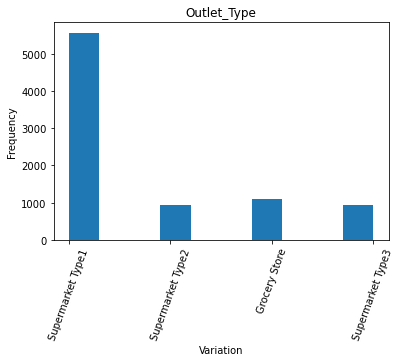

In [12]:
#I.3. Drawing graphs to explore and modify
#a. Histograms
i = "Outlet_Type"
#Input Item_Fat_Content Item_Type Outlet_Location_Type Outlet_Type
#for i in train.columns:
 #   if(str(train[i].dtypes) == "object" and str(i) != "Item_Identifier" and str(i) != "Outlet_Size"):
p = plt.hist(dataset[i])
plt.xlabel('Variation')
plt.ylabel('Frequency')
plt.tick_params(axis ='x', rotation = 70) 
plt.title(i)
plt.show()

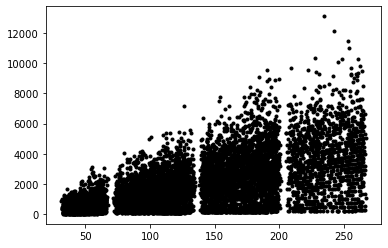

In [13]:
#b. Scatter plot
i = "Item_MRP"
#Input Item_Weight Item_MRP
plt.plot(dataset[i], dataset["Item_Outlet_Sales"], '.', color='black');


In [14]:
#print(dataset)

In [15]:
#One hot encoder: Fat content
# importing one hot encoder 
from sklearn.preprocessing import OneHotEncoder
#creating one hot encoder object 
onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(dataset.Item_Fat_Content.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(X, columns = ["FatContent: "+str(int(i)) for i in range(2)]) 
df = pd.concat([dataset, dfOneHot], axis=1)
#droping the country column 
df= df.drop(['Item_Fat_Content'], axis=1) 
#printing to verify 
print(df.head())

   Item_Weight  Item_Visibility              Item_Type  Item_MRP  \
0         9.30         0.016047                  Dairy  249.8092   
1         5.92         0.019278            Soft Drinks   48.2692   
2        17.50         0.016760                   Meat  141.6180   
3        19.20         0.070482  Fruits and Vegetables  182.0950   
4         8.93         0.070482              Household   53.8614   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  FatContent: 0  \
0               Tier 1  Supermarket Type1          3735.1380            1.0   
1               Tier 3  Supermarket Type2           443.4228            0.0   
2               Tier 1  Supermarket Type1          2097.2700            1.0   
3               Tier 3      Grocery Store           732.3800            0.0   
4               Tier 3  Supermarket Type1           994.7052            1.0   

   FatContent: 1  
0            0.0  
1            1.0  
2            0.0  
3            1.0  
4            0.0  


In [16]:
#One hot encoder: Outlet_Location_Type
#creating one hot encoder object 
#onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(df.Outlet_Location_Type.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(X, columns = ["Outlet_Location_Type: "+str(int(i)) for i in range(3)]) 
df = pd.concat([df, dfOneHot], axis=1)
#droping the country column 
df= df.drop(['Outlet_Location_Type'], axis=1) 
#printing to verify 
print(df.head())

   Item_Weight  Item_Visibility              Item_Type  Item_MRP  \
0         9.30         0.016047                  Dairy  249.8092   
1         5.92         0.019278            Soft Drinks   48.2692   
2        17.50         0.016760                   Meat  141.6180   
3        19.20         0.070482  Fruits and Vegetables  182.0950   
4         8.93         0.070482              Household   53.8614   

         Outlet_Type  Item_Outlet_Sales  FatContent: 0  FatContent: 1  \
0  Supermarket Type1          3735.1380            1.0            0.0   
1  Supermarket Type2           443.4228            0.0            1.0   
2  Supermarket Type1          2097.2700            1.0            0.0   
3      Grocery Store           732.3800            0.0            1.0   
4  Supermarket Type1           994.7052            1.0            0.0   

   Outlet_Location_Type: 0  Outlet_Location_Type: 1  Outlet_Location_Type: 2  
0                      1.0                      0.0                      

In [17]:
#One hot encoder: Outlet_Location_Type
#creating one hot encoder object 
#onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(df.Outlet_Type.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(X, columns = ["Outlet_Type: "+str(int(i)) for i in range(4)]) 
df = pd.concat([df, dfOneHot], axis=1)
#droping the country column 
df= df.drop(['Outlet_Type'], axis=1) 
#printing to verify 
print(df.head())

   Item_Weight  Item_Visibility              Item_Type  Item_MRP  \
0         9.30         0.016047                  Dairy  249.8092   
1         5.92         0.019278            Soft Drinks   48.2692   
2        17.50         0.016760                   Meat  141.6180   
3        19.20         0.070482  Fruits and Vegetables  182.0950   
4         8.93         0.070482              Household   53.8614   

   Item_Outlet_Sales  FatContent: 0  FatContent: 1  Outlet_Location_Type: 0  \
0          3735.1380            1.0            0.0                      1.0   
1           443.4228            0.0            1.0                      0.0   
2          2097.2700            1.0            0.0                      1.0   
3           732.3800            0.0            1.0                      0.0   
4           994.7052            1.0            0.0                      0.0   

   Outlet_Location_Type: 1  Outlet_Location_Type: 2  Outlet_Type: 0  \
0                      0.0                   

In [18]:
#One hot encoder: Item_Type
#creating one hot encoder object 
#onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(df.Item_Type.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(X, columns = ["Item_Type: "+str(int(i)) for i in range(16)]) 
df = pd.concat([df, dfOneHot], axis=1)
#droping the country column 
df= df.drop(['Item_Type'], axis=1) 
#printing to verify 
print(df.head())

   Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales  FatContent: 0  \
0         9.30         0.016047  249.8092          3735.1380            1.0   
1         5.92         0.019278   48.2692           443.4228            0.0   
2        17.50         0.016760  141.6180          2097.2700            1.0   
3        19.20         0.070482  182.0950           732.3800            0.0   
4         8.93         0.070482   53.8614           994.7052            1.0   

   FatContent: 1  Outlet_Location_Type: 0  Outlet_Location_Type: 1  \
0            0.0                      1.0                      0.0   
1            1.0                      0.0                      0.0   
2            0.0                      1.0                      0.0   
3            1.0                      0.0                      0.0   
4            0.0                      0.0                      0.0   

   Outlet_Location_Type: 2  Outlet_Type: 0  ...  Item_Type: 6  Item_Type: 7  \
0                      0.

In [19]:
from sklearn.model_selection import train_test_split

train ,test = train_test_split(df,test_size=0.4)       #test_size=0.5(whole_data)
    

In [20]:
#II. Decision tree regressor
#Spliting the training dataset
X = train.drop(['Item_Outlet_Sales'], axis = 1)
Y = train['Item_Outlet_Sales']

In [21]:
print(Y)

4407     587.2356
4714    2508.7344
2815    2067.3090
1732    3779.0808
8231    2693.8268
          ...    
977     1506.0396
1673    1322.2788
753     7833.8028
7244     287.6256
4816    4483.4972
Name: Item_Outlet_Sales, Length: 5113, dtype: float64


In [90]:
regr_1 = DecisionTreeRegressor(criterion='friedman_mse',\
                               max_depth=40, min_samples_split=2\
                                ,min_samples_leaf=1, min_weight_fraction_leaf=0.0, \
                               max_features=None, random_state=None, max_leaf_nodes=200, min_impurity_decrease=0.0, \
                               min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)
regr_2 = DecisionTreeRegressor(criterion='mse', splitter='best',\
                               max_depth=None, min_samples_split=2\
                                ,min_samples_leaf=1, min_weight_fraction_leaf=0.0, \
                               max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, \
                               min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)
regr_1 = regr_1.fit(X, Y)
regr_2 = regr_2.fit(X, Y)


In [91]:
# Predict
X_test = test.drop(['Item_Outlet_Sales'], axis = 1)
Y_test = test['Item_Outlet_Sales']
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

In [92]:
print(Y_test)

5308     638.5022
2730    2470.1180
6079     341.5554
3925    2936.1780
6232    2572.6512
          ...    
308     1039.9796
1924    1263.0226
7169     810.9444
4183     355.5372
7401    1640.5312
Name: Item_Outlet_Sales, Length: 3410, dtype: float64


In [93]:
from sklearn import tree


In [94]:
print(y_1)
print(len(y_1))

[1355.45343861 2273.65151667  661.00096634 ...  949.00796967  949.00796967
  949.00796967]
3410


In [95]:
#About tree 1:
print("The depth of the tree is: ", regr_1.get_depth())
print("The number of leaves is: ", regr_1.get_n_leaves())
#print("The parameters for this estimator are: ", regr_1.get_params())
print("R^2 on the training set: ", regr_1.score(X, Y))


The depth of the tree is:  19
The number of leaves is:  200
R^2 on the training set:  0.7439403874429114


In [96]:
print(y_2)

[1943.4702 2223.1062  656.4788 ... 1100.5674  711.0744  848.895 ]


In [99]:
#About tree 2:
print("The depth of the tree is: ", regr_2.get_depth())
print("The number of leaves is: ", regr_2.get_n_leaves())
#print("The parameters for this estimator are: ", regr_2.get_params())
print("R^2 on the training set: ", regr_2.score(X, Y))
print("Expect R^2 to be 1, as this is a fully grown tree, super overfitted")

The depth of the tree is:  35
The number of leaves is:  4983
R^2 on the training set:  1.0
Expect R^2 to be 1, as this is a fully grown tree, super overfitted


In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("RMSE for DTReg 1: " , np.sqrt(np.round(mean_squared_error(Y_test, y_1), 2)))
print("RMSE for DTReg 2: " , np.sqrt(np.round(mean_squared_error(Y_test, y_2), 2)))
print("MAE for DTReg 1: " , np.round(mean_absolute_error(Y_test, y_1), 2))
print("MAE for DTReg 2: " , np.round(mean_absolute_error(Y_test, y_2), 2))
print("RSquared for DTReg 1: " , np.round(r2_score(Y_test, y_1), 2))
print("RSquared for DTReg 2: " , np.round(r2_score(Y_test, y_2), 2))



RMSE for DTReg 1:  1270.1813098924106
RMSE for DTReg 2:  1574.5520410580273
MAE for DTReg 1:  843.25
MAE for DTReg 2:  1095.64
RSquared for DTReg 1:  0.46
RSquared for DTReg 2:  0.16


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

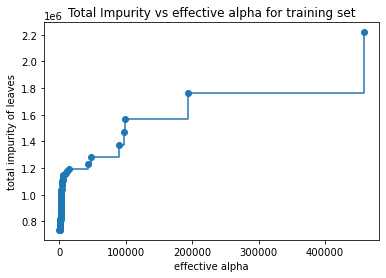

In [101]:
#Tree pruning for our testing tree using cost_complexity scores
#With Tree Score = Sums_Square_Error + ccp_alpha * NumberofLeaves
#Score = SSR + a*T
path = regr_1.cost_complexity_pruning_path(X,Y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
#Plotting impurities vs effective alpha
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")


In [102]:
#Building a bunch of different ccp_alphas
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, Y)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(\
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 3 with ccp_alpha: 655710.8042000225


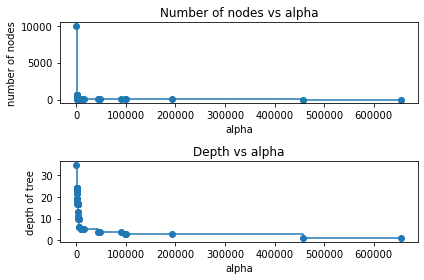

In [103]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

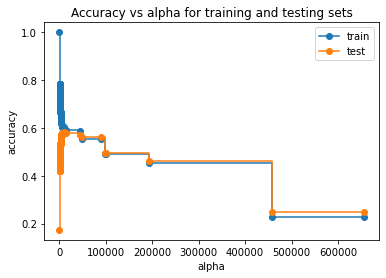

In [104]:
train_scores = [clf.score(X, Y) for clf in clfs]
test_scores = [clf.score(X_test, Y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

Here we find that, at ccp_alpha = about 30,000, the accuracy for both sets is best, at about 60%, hence:

In [105]:
regr_3 = DecisionTreeRegressor(criterion='mse',\
                               max_depth=40, min_samples_split=2\
                                ,min_samples_leaf=1, min_weight_fraction_leaf=0.0, \
                               max_features=None, random_state=None, max_leaf_nodes=200, min_impurity_decrease=0.0, \
                               min_impurity_split=None, presort='deprecated', ccp_alpha=30000)

regr_3 = regr_3.fit(X, Y)


In [106]:
y_3 = regr_3.predict(X_test)


In [107]:
print(y_3)

[1707.25317918 3797.46174913  834.25496591 ...  834.25496591  834.25496591
  834.25496591]


In [108]:
#About tree 3:
print("The depth of the tree is: ", regr_3.get_depth())
print("The number of leaves is: ", regr_3.get_n_leaves())
#print("The parameters for this estimator are: ", regr_1.get_params())
print("R^2 on the training set: ", regr_3.score(X, Y))


The depth of the tree is:  4
The number of leaves is:  9
R^2 on the training set:  0.586161115604991


In [110]:
print("RMSE for DTReg 3: " , np.sqrt(np.round(mean_squared_error(Y_test, y_3), 2)))
print("RMSE for DTReg 2: " , np.sqrt(np.round(mean_squared_error(Y_test, y_2), 2)))
print("MAE for DTReg 3: " , np.round(mean_absolute_error(Y_test, y_3), 2))
print("MAE for DTReg 2: " , np.round(mean_absolute_error(Y_test, y_2), 2))
print("RSquared for DTReg 3: " , np.round(r2_score(Y_test, y_3), 2))
print("RSquared for DTReg 2: " , np.round(r2_score(Y_test, y_2), 2))


RMSE for DTReg 3:  1128.4366309190782
RMSE for DTReg 2:  1574.5520410580273
MAE for DTReg 3:  795.95
MAE for DTReg 2:  1095.64
RSquared for DTReg 3:  0.57
RSquared for DTReg 2:  0.16


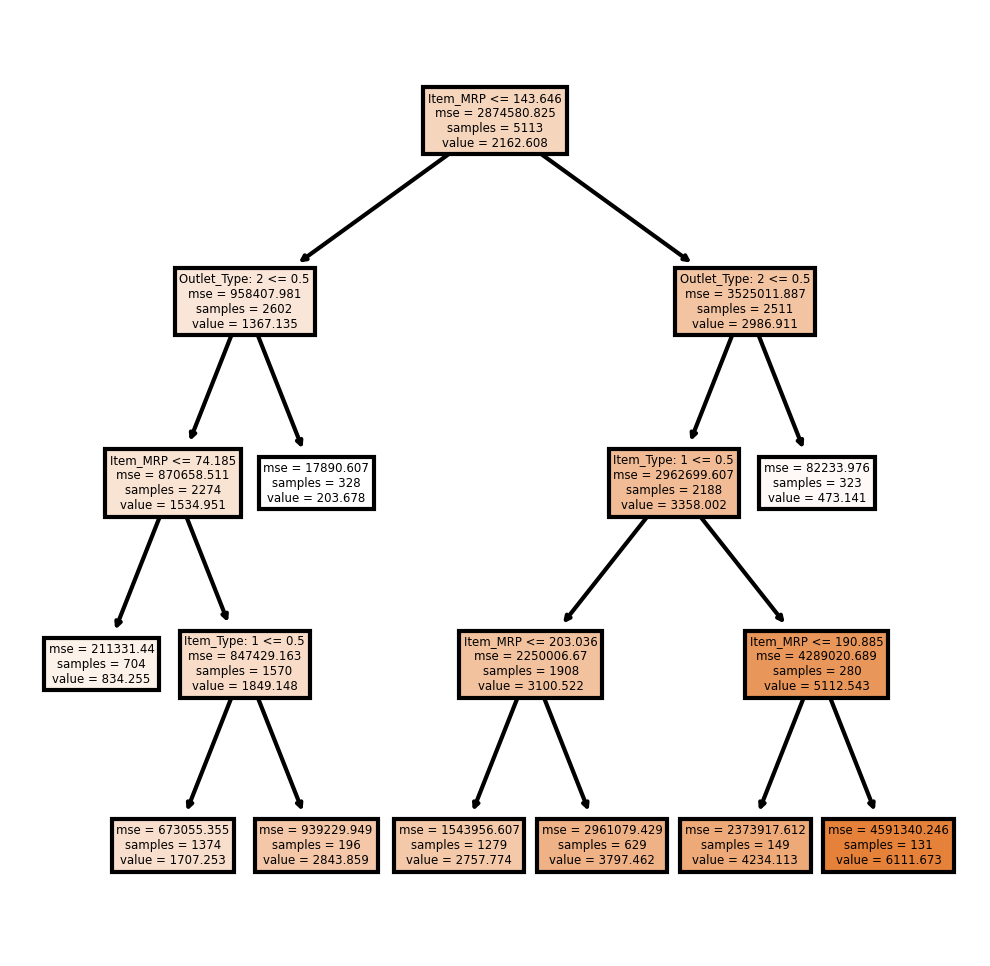

In [122]:
#Plotting the trees
#features
fn=['Item_Weight','Item_Visibility','Item_MRP','FatContent: 0','FatContent: 1'\
   'Outlet_Location_Type: 0','Outlet_Location_Type: 1','Outlet_Location_Type: 2'\
   'Outlet_Type: 0','Outlet_Type: 1','Outlet_Type: 2','Outlet_Type: 3', 'Item_MRP'\
   'Item_Type: 0', 'Item_Type: 1','Item_Type: 2','Item_Type: 3',\
   'Item_Type: 4', 'Item_Type: 5','Item_Type: 6','Item_Type: 7',\
   'Item_Type: 8', 'Item_Type: 9','Item_Type: 10','Item_Type: 11',\
   'Item_Type: 12', 'Item_Type: 13', 'Item_Type: 14', 'Item_Type: 15']

#cn=['setosa', 'versicolor', 'virginica']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(regr_3, feature_names = fn, filled = True);
#print(Tree_plot)
fig.savefig('RegressionTree_WalmartSales.png')


In [124]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(ccp_alpha=30000)
regr = regr.fit(X, Y)
y_Forest = regr.predict(X_test)


In [126]:
#About forest:
#print("The depth of the tree is: ", regr.get_depth())
#print("The number of leaves is: ", regr.get_n_leaves())
#print("The parameters for this estimator are: ", regr_1.get_params())
print("R^2 on the training set: ", regr.score(X, Y))


R^2 on the training set:  0.5989509888279152


In [127]:
print("RMSE for DTReg Forest: " , np.sqrt(np.round(mean_squared_error(Y_test, y_Forest), 2)))
print("RMSE for DTReg 2: " , np.sqrt(np.round(mean_squared_error(Y_test, y_2), 2)))
print("MAE for DTReg Forest: " , np.round(mean_absolute_error(Y_test, y_Forest), 2))
print("MAE for DTReg 2: " , np.round(mean_absolute_error(Y_test, y_2), 2))
print("RSquared for DTReg Forest: " , np.round(r2_score(Y_test, y_Forest), 2))
print("RSquared for DTReg 2: " , np.round(r2_score(Y_test, y_2), 2))


RMSE for DTReg Forest:  1116.2415061266984
RMSE for DTReg 2:  1574.5520410580273
MAE for DTReg Forest:  787.45
MAE for DTReg 2:  1095.64
RSquared for DTReg Forest:  0.58
RSquared for DTReg 2:  0.16


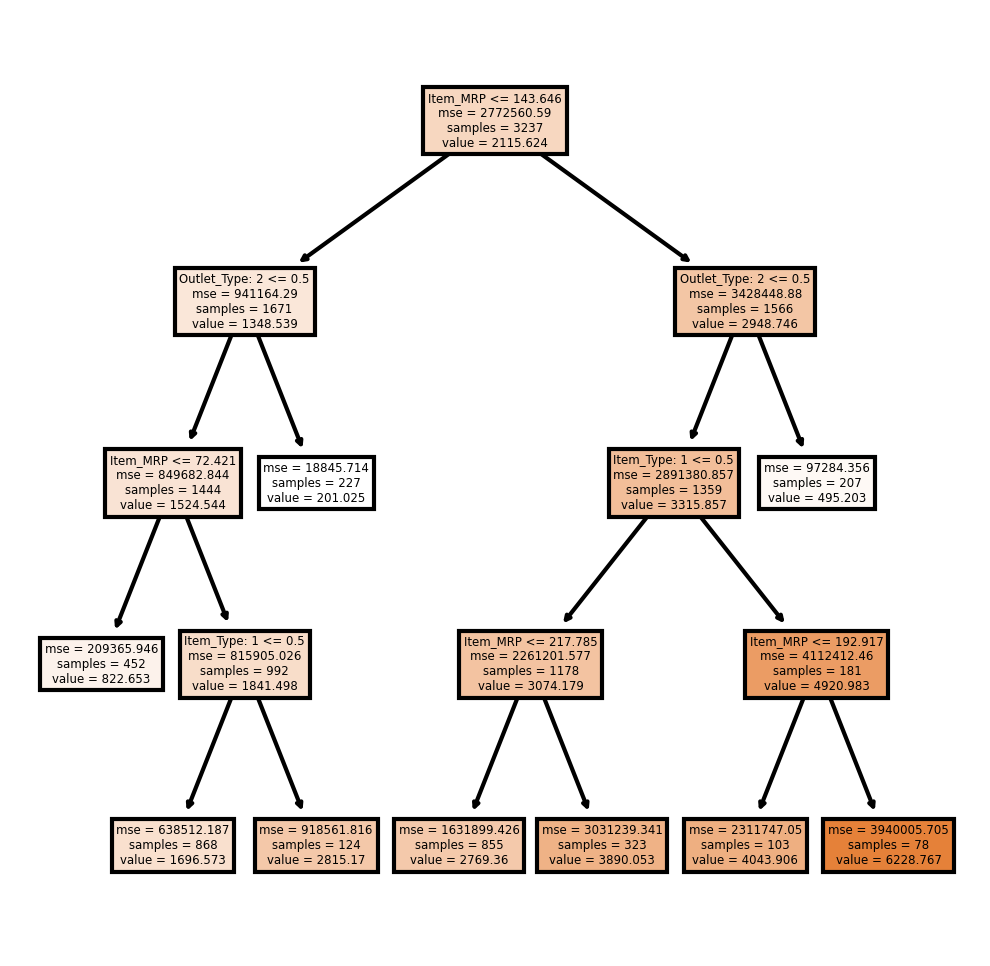

In [135]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(regr.estimators_[0],\ #Replace index to see other trees
               feature_names = fn,\
               filled = True);

#print(Tree_plot)
fig.savefig('RegressionForest_WalmartSales.png')
